# **Notebook Esame AVRC (Parte 2)**

## Loading Modules

In [ ]:
import shutil

from pathlib import Path

import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager

import math

from dataviz import utility as dviz

from enum import Enum

# Per quantizzazione gaussiana
from scipy import stats
import scipy
from numpy import random

# x barra caricamento
import sys

# Per animazione delle gif
import imageio

## reproducibility
RND_SEED = 123456

import networkx.classes.function as nxfunc

%matplotlib inline

## Save and Load Result Data

In [ ]:
# save numpy array as csv file
from numpy import asarray

# Metodi di utility
def make_save_data(a1, a2, a3, a4, a5, a6):
    return asarray([a1, a2, a3, a4, a5, a6])

def save_data(data, save_path):
    with open(save_path, 'wb') as file_data:
        np.save(file_data, data)

def load_data(save_path):
    data = None
    with open(save_path, 'rb') as file_data:
        data = np.load(file_data)
    return data


# Wrapper da usare
# Salvare Dati
def save_aggregated_data(sir_infects_d, sir_timing_d, sirq_infects_d, sirq_timing_d):
    data = make_save_data(sir_infects_d, sirq_timing_d, sirq_infects_d, sirq_timing_d)
    Path("./array_data/aggregated/").mkdir(parents=True, exist_ok=True)
    save_path = "./array_data/aggregated/aggregated_data.npy"
    save_data(data, save_path)

def save_temporal_data(temporal_sir_infects_d, temporal_sir_timing_d, temporal_sirq_infects_d, temporal_sirq_timing_d):
    data = make_save_data(temporal_sir_infects_d, temporal_sir_timing_d, temporal_sirq_infects_d, temporal_sirq_timing_d)
    Path("./array_data/temporal/").mkdir(parents=True, exist_ok=True)
    save_path = "./array_data/temporal/temporal_data.npy"
    save_data(data, save_path)

# Leggere Dati
def load_aggregated_data():
    return load_data("./array_data/aggregated/aggregated_data.npy")

def load_temporal_data():
    return load_data("./array_data/temporal/temporal_data.npy")

## Preparazione Dati

In [ ]:
node_options_gif = {"edgecolors": "tab:gray", "node_size": 400, "alpha": 0.9}
network_data = {
    "path": "ants_proximity",
    "prefix": "ant_mersch_",
    "chosen_colony": "col2",
    "threshold":  4
}
figures = {}

In [ ]:
def read_colonies_files(path, prefix, choosen_colony = None, exclude_colony_ids=[], timesteps_span=(-math.inf,math.inf)):
    colonies = {}
    network_files = Path(path).glob(f"{prefix}*")

    for file_path in sorted(network_files): # read sorted files to preserve the right temporal sequence  
        colony_id, timestep = file_path.stem[len(prefix):].split("_")[0:2] # extract colony number and timestep
        # Se ho impostato una particolare colonia
        # Se sto leggendo roba di altre colonie mi fermo, è inutile
        if choosen_colony != None:
            if colony_id != choosen_colony:
                continue
        if colony_id not in exclude_colony_ids:
            timestep_number = int(timestep[3:]) # extract int representation discarding "day" prefix
            if timesteps_span[0] <= timestep_number <= timesteps_span[1]:
                if colony_id in colonies:
                    timesteps_colony = colonies[colony_id]
                    network = nx.read_graphml(file_path)
                    timesteps_colony.append(network)
                else: # first time step
                    colonies[colony_id] = [nx.read_graphml(file_path)]

    return colonies

# Riduzione della rete (troppi archi, diventa troppo lunga fare roba)
def global_treshold_sparsification(G, threshold, attribute='weight'):
    sparsified = G.copy()
    sparsified.remove_edges_from([(n1, n2) for n1, n2, w in sparsified.edges(data=attribute) if w < threshold])
    return sparsified

In [ ]:
# Caricamento delle reti, prendo solo la colonia che mi interessa
Gs = read_colonies_files(network_data["path"], network_data["prefix"], choosen_colony=network_data["chosen_colony"])[network_data["chosen_colony"]]
print (f"# di snapshots: {len(Gs)}")

# Riduco la rete temporale (taglio archi)
threshold =  network_data["threshold"]
Gs_cut = []
for snapshot in Gs:
    # Riduzione del numero di archi
    sparsified = global_treshold_sparsification(snapshot, threshold)
    Gs_cut.append(sparsified)

# di snapshots: 41


# 2. Network Dynamics

In [ ]:
# Information Spreading: (inter e out-cluster) secondo 3 strategie:
# 1- Rimozione random dei nodi
# 2- Rimozione specifica (secondo degree/centralità/misura sensata) nodi che possono provocare + danni (hub)
# 3- Fare partire i seed in una community o in un altra (al posto che guardare gli attributi) e vedere come si diffonde

# Epidemics:
# fare test con sir e sis, utilizzando un valore di probabilità di contagio medio fissato e poi ogni formica a partire da questo,
# in base ai suoi attributi (dimensione, eta e luogo nel nest) ha + o meno probabilità di essere contagiata (se sono nel nest è meno probabile x esempio)
# Qua facciamo considerazioni sui risultati ottenuti in questa sezione con quelli attesi dalla sezione precedente sui vari modelli di reti
# Dire se i risultati ottenuti li aspettavamo o meno

dynamic_data = {
    "p": 0.8,   # Probabilità di contagio
    "t_rec": 3, # Tempo di recupero (tempo in cui rimango infetto e poi divento immune/suscettibile)
    "t_imm": 4, # Tempo di immunità dopo essere diventato 'immune', prima di tornare suscettibile
    # Questi 3 permettono di modificare poi i valori di p, t_rec, t_imm in base al tipo di 'lavoro' svolto dalla formica
    "nurse_resistance": 1,
    "cleaner_resistance": 1,
    "forager_resistance": 1
}

temporal_data = {
    # Questi 4 vengono calcolati dai dati, lasciarli così
    "max_body_size": -math.inf,
    "min_body_size": math.inf,
    "max_age": -math.inf,
    "min_age": math.inf,
    "queen": "",
    "intervals": None
}

gauss_settings = {
    "mu": 0,        # Media
    "sigma": 0.6,   # Varianza, + grande, più intervalli grandi
    "min": -1,      # lower bound = -1
    "max": +1,      # upper bound = +1
    "r": 2          # Number of cuts from 0 -> 1 and 0 -> -1
}

# Gestisce il tipo di nodo nella rete in modo semplice
class EpidemicNodeType(Enum):
    Suscettibile = 1
    Infetto = 2
    Immune = 3

def print_temporal_data():
    print("| -----     -----     -----     ----- |")
    print("Temporal Data:")
    print("Max body size:", temporal_data["max_body_size"])
    print("Min body size:", temporal_data["min_body_size"])
    print("Max age(days):", temporal_data["max_age"])
    print("Min age(days):", temporal_data["min_age"])
    print("Queen:", temporal_data["queen"])
    print("Intervals:", temporal_data['intervals'])
    print("| -----     -----     -----     ----- |")
    
# generate Gaussian function
def gauss(x):
    return stats.norm.pdf(x, gauss_settings["mu"], gauss_settings["sigma"])

## Metodi&nbsp;per&nbsp;suddivisione&nbsp;intervallo&nbsp;gaussiano

In [ ]:
# Quantizza e ritorna un alfabeto sotto forma di dizionario -> {centro(parola): (min_val, max_val)}
# r indica il numero di simboli
# worseness indica di quanto peggiora cambiando gli intervalli (il centro avrà i top della specie, all'esterno saranno 'peggiori')
def quanticize_interval(options, worseness=2):
    dim = (options["max"] - options["min"]) / (2 * float(options["r"])) # 2 è la dimensione -1 -> +1, ma devo dividere per 2r, quindi rimane 1/r
    cont = 0 # options["min"] #Ottimizzazione, i risultati a dx o a sx sono uguali, conto solo quelli a dx e creo gli intervalli anche x quelli a sx
    guassian = random.normal(loc=options["mu"], scale=options["sigma"])
    results = []
    normalize_gauss, _ = scipy.integrate.quad(gauss, options["min"], options["max"]) #valore, errore stimato
    # Mi calcolo la lunghezza degli intervalli gaussiani usando le 2*r suddivisioni dell'intervallo base
    while cont < options["max"]:
        min_val = cont
        next_val = cont + dim
        # Gaussian Integral between current and next all divided by integral between -1 and 1 (to normalize result) and multiplied by 2
        result, _ = scipy.integrate.quad(gauss, min_val, next_val) # valore, errore stimato
        normalized_result = 2 * result / normalize_gauss
        results.insert(0, (min_val, next_val, normalized_result))
        cont = next_val
    results.reverse()
    # A partire dalle lunghezze degli intervalli, mi costruisco il centro di questi facendo punto_iniziale_intervallo + lunghezza / 2
    # X evitare scritte enormi, taglio dopo la 3 cifra decimale
    intervals = {}
    current = 0
    interval_id = 0
    for min_r, max_r, length_r in results:
        middle = current + length_r / 2
        middle = float("{:0.2f}".format(middle))
        intervals[str(middle)] = (interval_id, float("{:0.2f}".format(current)), float("{:0.2f}".format(current + length_r)))
        # Dato che ho calcolato solo i valori x i numeri positivi (quelli negativi sono uguali ma con il -)
        # Copio il centro appena trovato ma con le coordinate opposte
        intervals[str(-middle)] = (-interval_id, float("{:0.2f}".format(-current)), float("{:0.2f}".format(-(current + length_r))))
        interval_id += worseness
        current += length_r
    return intervals

## Metodi&nbsp;per&nbsp;preparazione&nbsp;data&nbsp;per&nbsp;modelling&nbsp;dinamico

In [ ]:
# Mi prendo i valori dalla rete, che mi permettono poi di creare intervalli e modificare i valori di recupero/resistenza delle singole formiche
def get_temporal_data(G, temporal_data):
    min_body = temporal_data["min_body_size"]
    min_age = temporal_data["min_age"]
    max_body = temporal_data["max_body_size"]
    max_age = temporal_data["max_age"]
    queen = temporal_data["queen"]
    for node_name in G.nodes:
        # Non so xkè ma non mi tira il nodo ma solo il suo nome
        node = G.nodes[node_name]
        if node.get("body_size") != None:
            if node["body_size"] < min_body:
                min_body = node["body_size"]
            if node["body_size"] > max_body:
                max_body = node["body_size"]
        
        if node.get("age(days)") != None:
            if node["age(days)"] < min_age:
                min_age = node["age(days)"]
            if node["age(days)"] > max_age:
                max_age = node["age(days)"]
                queen = node_name

    temporal_data["max_body_size"] = max_body
    temporal_data["min_body_size"] = min_body
    temporal_data["max_age"] = max_age
    temporal_data["min_age"] = min_age
    temporal_data["queen"] = queen

def generate_temporal_data(Gs, temporal_data):
    [get_temporal_data(G, temporal_data) for G in Gs]

def normalize_value(value, min_x, max_x):
    return (gauss_settings['max'] - gauss_settings["min"]) * ((value - min_x) / (max_x - min_x)) + gauss_settings["min"]

def get_interval(value):
    interval_id = 1
    for _, (i_id, off1,  off2) in temporal_data['intervals'].items():
        min_value = min(off1, off2)
        max_value = max(off1, off2)
        if value >= min_value and value <= max_value:
            interval_id = i_id
            break
    return interval_id

def my_abs(value):
    if value >= 0:
        return value
    else:
        return -value

# METODI X MODELLI SIR, SIS E SIRS
def prepare_epidemic_data(G):
    G_epidemic_data = {}
    for node_name in G.nodes:
        node = G.nodes[node_name]
        node_prob = dynamic_data["p"]
        node_recovery  = dynamic_data["t_rec"]
        node_immunity = dynamic_data["t_imm"]

        # Modificatore del body_size -> probabilità di infettarsi
        if node.get("body_size") != None:
            node_bs_norm = normalize_value(node['body_size'], temporal_data['min_body_size'], temporal_data['max_body_size'])
            interval = get_interval(node_bs_norm) / 100 # per avere valori da 0 a 1 (finchè gli intervalli sono meno di boh, tipo 60)
            node_prob = float("{:0.2f}".format(node_prob + my_abs(interval)))

        # Modificatore dell'età -> tempo di rimanere infettato e tempo di immunità
        if node.get("age(days)") != None:
            node_age_norm = normalize_value(node['age(days)'], temporal_data['min_age'], temporal_data['max_age'])
            interval = get_interval(node_age_norm) / 2
            node_recovery = int(node_recovery + my_abs(interval)) #Se sto in fasce esterne sono per + tempo contagioso
            node_immunity = int(node_immunity - my_abs(interval)) #Se sto in fasce esterne sono per - tempo immune

        # Aggiungo dati relativi al nodo 
        G_epidemic_data[node_name] =  (node_prob, node_recovery, node_immunity)
    return G_epidemic_data

## Metodi&nbsp;per&nbsp;Modelling&nbsp;Dinamico&nbsp;(sir,&nbsp;sis,&nbsp;sirs,&nbsp;sir_quarantine)

In [ ]:
# Utility methods
def drawProgressBar(percent, barLen = 20):
    sys.stdout.write("\r")
    sys.stdout.write("[{:<{}}] {:.0f}%".format("=" * int(barLen * percent), barLen, percent * 100))
    sys.stdout.flush()

def decision(rng, probability):
    return rng.random() <= probability

def decision_w(rng, probability, weight):
    return np.any(rng.random(size=weight) <= probability)

# Rimuovo alcuni dei vicini con una probabilità data
def remove_neighbours(G, node_name, rng, remove_perc):
    edges = set([(n1, n2) for n1, n2 in G.edges if n1 == node_name])
    edges = edges.union(set([(n1, n2) for n1, n2 in G.edges if n2 == node_name]))
    for edge in edges:
        if decision(rng, remove_perc):
            G.remove_edge(*edge)

# Metodo che dato il nome di un nodo, prova ad infettare tutti i suoi vicini
def infetta_vicini(G, G_data, node_name, rng):
    # Mi prendo i vicini e vedo se posso infettarli (vicini che ho incontrato o che hanno incontrato me)
    ant_edges = set([(n2, w) for n1, n2, w in G.edges(data='weight') if n1 == node_name])
    ant_edges = ant_edges.union(set([(n1, w) for n1, n2, w in G.edges(data='weight') if n2 == node_name]))
    # X ogni vicino
    for neigh, w in ant_edges:
        neigh_node = G.nodes[neigh]
        # Se il vicino è suscettibile, provo a vedere se riesco ad infettarlo BWHAHAHAHAHAHHAHA
        if neigh_node["epidemic_status"] == EpidemicNodeType.Suscettibile:
            neigh_prob, neigh_recovery, _ = G_data[neigh] #il 3° è tempo di immunità, non usato x questa funzione
            # Vedo se riesco ad infettarlo
            if decision_w(rng, neigh_prob, w):
                neigh_node["epidemic_status"] = EpidemicNodeType.Infetto
                neigh_node["epidemic_timer"] = neigh_recovery
                neigh_node["epidemic_lock"] = True # voglio che faccia roba da infetto solo al prossimo giro
    # Fine for vicini

# Metodo che gestisce il modello dinamico
def dynamic_model(network, starting_infected_nodes, dynamic_model_function, rnd_seed, max_repetitions=100, save_every_n=1, show_progress=False):
    G = network.copy()
    temporal_data = []
    G_data = prepare_epidemic_data(G)
    rng = random.default_rng(rnd_seed)
    # Inizializzazione rete
    # Tutti i nodi sono suscettibili
    for node_name in G.nodes:
        node = G.nodes[node_name]
        node["epidemic_status"] = EpidemicNodeType.Suscettibile
    # I nodi decisi sono infetti
    for node_name in starting_infected_nodes:
        node = G.nodes[node_name]
        node['epidemic_status'] = EpidemicNodeType.Infetto
        _, node_recovery, _ = G_data[node_name]
        node['epidemic_timer'] = node_recovery
    # Eseguo finchè ho raggiunto il numero massimo di ripetizioni (giusto x evitare cicli infiniti)
    # o se la situazione si è stabilizzata
    stabilized = False
    current_repetition = 0
    infected_count = 0
    max_infected_count = len(starting_infected_nodes)
    # Mi salvo la situazione iniziale
    temporal_data.insert(0, (current_repetition, max_infected_count , G.copy()))
    while current_repetition < max_repetitions and stabilized == False:
        if show_progress == True:
            drawProgressBar(current_repetition / max_repetitions)
        # Resetto i lock
        for node_name in G.nodes:
            node = G.nodes[node_name]
            node["epidemic_lock"] = False
        # Utilizzo modello
        infected_count = dynamic_model_function(G, G_data, rng)
        # Mi salvo la stima di quanti sono stati infettati
        if infected_count > max_infected_count:
            max_infected_count = infected_count
        # Se il numero di infetti è zero, il modello è stabilizzato ed ha terminato
        if infected_count == 0:
            stabilized = True
        current_repetition += 1
        # Aggiungo la situazione attuale della rete solo se sono in un istante richiesto
        if current_repetition % save_every_n == 0:
            temporal_data.insert(0, (current_repetition, infected_count, G.copy()))
    # Fine while
    if show_progress == True:
        drawProgressBar(1)
    # Aggiungo la situazione finale (per sicurezza se save_every_n != 1, altrimenti sicuro la ha salvata prima)
    if save_every_n != 1:
        temporal_data.insert(0, (current_repetition, infected_count, G.copy()))
    temporal_data.reverse() # Ordino in modo temporale i dati temporali
    return temporal_data

# Modelli dinamici che gestiscono il comportamento della rete ad ogni iterazione, Ritornano se la rete è stabilizzata oppure no
# Modello 1- SIR
# Suscettibili -> Infetti -> Immuni
def model_sir(G, G_data, rng):
    infected_count = 0
    # Gestione spread infezione
    for node_name in G.nodes:
        node = G.nodes[node_name]
        # Sono stato infettato IN QUESTO GIRO da qualcun'altro, e x questo giro non fo nulla
        # Oppure se non sono infettato o sono rimosso/immune, non faccio nulla
        if node["epidemic_lock"] == True or node["epidemic_status"] == EpidemicNodeType.Suscettibile or node["epidemic_status"] == EpidemicNodeType.Immune:
            continue
        # Se sono qua, sicuramente sono stato infettato in un qualche istante precedente
        # Riduco il cont di infezione
        node["epidemic_timer"] -= 1
        # Se ho finito il tempo di infezione, divento rimosso/immune e non faccio nulla
        if node["epidemic_timer"] == 0:
            node["epidemic_status"] = EpidemicNodeType.Immune
            continue
        # Se sono invece ancora infetto allora faccio cose con i vicini
        infected_count += 1
        # Provo ad infettare i vicini
        infetta_vicini(G, G_data, node_name, rng)
    # Fine for nodi
    # Ritorno il numero di infetti in questo istante di tempo
    return infected_count

# Modello 2- SIS
# Abbiamo solo + Suscettibili ed infetto, dopo tot tempo infetti tornano suscettibili
def model_sis(G, G_data, rng):
    infected_count = 0
    # Gestione spread infezione
    for node_name in G.nodes:
        node = G.nodes[node_name]
        # Sono stato infettato IN QUESTO GIRO da qualcun'altro, e x questo giro non fo nulla
        # Oppure se non sono infettato, non faccio nulla
        if node["epidemic_lock"] == True or node["epidemic_status"] == EpidemicNodeType.Suscettibile:
            continue
        # Se sono qua, sicuramente sono stato infettato in un qualche istante precedente
        # Riduco il cont di infezione
        node["epidemic_timer"] -= 1
        # Se ho finito il tempo di infezione, divento rimosso/immune e non faccio nulla
        if node["epidemic_timer"] == 0:
            node["epidemic_status"] = EpidemicNodeType.Suscettibile
            node["epidemic_lock"] = True # voglio che posso essere infettato nuovamente solo al prossimo giro
            continue
        # Se sono invece ancora infetto allora faccio cose con i vicini
        infected_count += 1
        # Provo ad infettare i vicini
        infetta_vicini(G, G_data, node_name, rng)
    # Fine for nodi
    # Ritorno il numero di infetti in questo istante di tempo
    return infected_count

# Modello 3- SIRS
# Unione di SIR e SIS, Suscettibile -> Infetto -> immune/rimosso -> Suscettibile -> ...
def model_sirs(G, G_data, rng):
    infected_count = 0
    # Gestione spread infezione
    for node_name in G.nodes:
        node = G.nodes[node_name]
        # Se sono stato infettato in questo giro o sono suscettibile non faccio nulla (a questo giro)
        if node["epidemic_lock"] == True or node["epidemic_status"] == EpidemicNodeType.Suscettibile:
            # Passo al prossimo nodo
            continue

        # Se sono Immune, riduco il tempo di immunità
        if node["epidemic_status"] == EpidemicNodeType.Immune:
            node["epidemic_timer"] -= 1
            # Se è arrivato a zero, dal prossimo turno divento di nuovo suscettibile
            if node["epidemic_timer"] == 0:
                node["epidemic_status"] = EpidemicNodeType.Suscettibile
                node["epidemic_lock"] = True
            # Passo al prossimo nodo
            continue

        # Altrimenti se sono stato infettato in un qualche istante precedente
        # Riduco il cont di infezione
        node["epidemic_timer"] -= 1
        # Se ho finito il tempo di infezione, divento rimosso e non faccio nulla
        if node["epidemic_timer"] == 0:
            _, _, node_immunity = G_data[node_name]
            node["epidemic_status"] = EpidemicNodeType.Immune
            node["epidemic_timer"] = node_immunity
            node["epidemic_lock"] = True # voglio che posso essere infettato nuovamente solo al prossimo giro
            # Passo al prossimo nodo
            continue
        # Se sono invece ancora infetto allora faccio cose con i vicini
        infected_count += 1
        # Provo ad infettare i vicini
        infetta_vicini(G, G_data, node_name, rng)
    # Fine for nodi
    # Ritorno il numero di infetti in questo istante di tempo
    return infected_count

# Modello sir con quarantena delle formiche (se una diventa infetta, taglio i suoi rapporti con le vicine)
def model_sir_quarantine(G, G_data, rng, p_quarantine=0.8):
    infected_count = 0
    # Gestione spread infezione
    for node_name in G.nodes:
        node = G.nodes[node_name]
        # Sono stato infettato IN QUESTO GIRO da qualcun'altro, e x questo giro non fo nulla
        # Oppure se non sono infettato o sono rimosso/immune, non faccio nulla
        if node["epidemic_lock"] == True or node["epidemic_status"] == EpidemicNodeType.Suscettibile or node["epidemic_status"] == EpidemicNodeType.Immune:
            continue
        # Se sono qua, sicuramente sono stato infettato in un qualche istante precedente
        # Riduco il cont di infezione
        node["epidemic_timer"] -= 1
        # Se ho finito il tempo di infezione, divento rimosso/immune e non faccio nulla
        if node["epidemic_timer"] == 0:
            node["epidemic_status"] = EpidemicNodeType.Immune
            continue
        # Se sono invece ancora infetto allora faccio cose con i vicini
        infected_count += 1
        # Prima di tutto, taglio di p_quarantine% il numero di rapporti con i vicini
        remove_neighbours(G, node_name, rng, p_quarantine)
        # Provo ad infettare i vicini
        infetta_vicini(G, G_data, node_name, rng)
    # Fine for nodi
    # Ritorno il numero di infetti in questo istante di tempo
    return infected_count

# Wrapper richiamabili dall'esterno
def sir(epidemic_network, starting_infected_nodes, rnd_seed, max_repetitions=100, save_every_n=1, show_progress=False):
    return dynamic_model(epidemic_network, starting_infected_nodes, model_sir, rnd_seed, max_repetitions=max_repetitions, save_every_n=save_every_n, show_progress=show_progress)
def sir_quarantine(epidemic_network, starting_infected_nodes, rnd_seed, max_repetitions=100, save_every_n=1, show_progress=False):
    return dynamic_model(epidemic_network, starting_infected_nodes, model_sir_quarantine, rnd_seed, max_repetitions=max_repetitions, save_every_n=save_every_n, show_progress=show_progress)
def sis(epidemic_network, starting_infected_nodes, rnd_seed, max_repetitions=100, save_every_n=1, show_progress=False):
    return dynamic_model(epidemic_network, starting_infected_nodes, model_sis, rnd_seed, max_repetitions=max_repetitions, save_every_n=save_every_n, show_progress=show_progress)
def sirs(epidemic_network, starting_infected_nodes, rnd_seed, max_repetitions=100, save_every_n=1, show_progress=False):
    return dynamic_model(epidemic_network, starting_infected_nodes, model_sirs, rnd_seed, max_repetitions=max_repetitions, save_every_n=save_every_n, show_progress=show_progress)

## Preparazione Dati Temporali

In [ ]:
# Metodo x fare la rete aggregata
def make_aggregated_network(network_snapshots):
    agg_dict =  nx.to_dict_of_dicts(network_snapshots[0].copy())
    snapshots = network_snapshots[1:]
    for snapshot in snapshots: # loop trough snapshot's time
        snapshot_dict = nx.to_dict_of_dicts(snapshot.copy())
        for ant in snapshot_dict: # loop trough ants
            for neigh in snapshot_dict[ant]: # loop trough ant's neighobours
                if neigh in agg_dict[ant]:
                    agg_dict[ant][neigh]['weight'] += snapshot_dict[ant][neigh]['weight'] # sum up weights

    aggregated_network = nx.from_dict_of_dicts(agg_dict)
    ## imposto dizionari ai nodi
    for node_name in aggregated_network.nodes:
        node_snap = snapshots[0].nodes[node_name]
        # Se non ho elementi nel dizionario passo al prossimo passo
        if len(node_snap) == 0:
            continue
        node = aggregated_network.nodes[node_name]
        for key in node_snap.keys():
            node[key] = node_snap[key]
            #nxa.set_node_attributes(aggregated_network, node_snap[key], node)
    ##
    return aggregated_network

In [ ]:
# PREPARAZIONE DATI

generate_temporal_data(Gs_cut, temporal_data)
temporal_data['intervals'] = quanticize_interval(gauss_settings)
print_temporal_data()
#"Intervals: (middle: (interval_worseness, min, max))"
# posso usare interval_worseness x aumentare/ridurre il valore di recupero/prob contagio

##
agg_network = make_aggregated_network(Gs_cut)

| -----     -----     -----     ----- |
Temporal Data:
Max body size: 308.006
Min body size: 112.00399999999999
Max age(days): 1453
Min age(days): 0
Queen: Ant592
Intervals: {'0.33': (0, 0.0, 0.66), '-0.33': (0, 0.0, -0.66), '0.83': (2, 0.66, 1.0), '-0.83': (-2, -0.66, -1.0)}
| -----     -----     -----     ----- |


## Esecuzione dei tre modelli dinamici sulla rete aggregata (SIR, SIS, SIRS)

Utilizzando come dati:<br>
Probabilità di infezione = 0.1<br>
Tempo di infezione = 3<br>
Tempo di immunità = 5<br>

- SIR:<br> Conclude generalmente in circa 10 passaggi
- SIS:<br> Non riesce a raggiungere la stabilità in un numero 'basso' di passaggi<br>(Ci sta, pur avendo 0.1 come probabilità c'è da ricordarsi che la densità è altissima, quindi la mia probabilità di ammalarmi rimane alta)<br>
- SIRS:<br> Con queste specifiche, si comporta in modo analogo a SIR<br>Riducendo il tempo di immunità di qualche istante(1-2) fa si che il comportamento di SIRS si avvicini a quello di SIS

In [ ]:
epidemic_node_colors = {EpidemicNodeType.Suscettibile: 'green', EpidemicNodeType.Infetto: 'red', EpidemicNodeType.Immune: 'blue'}
epidemic_node_names = ['Suscettibile', 'Infetto', 'Immune']

# Metodo che mi tira fuori i status epidemici dei nodi della rete
def get_nodes_color(network, characteristic_name):
    nodes_color = []
    for node_name in network.nodes:
        node = network.nodes[node_name]
        nodes_color.insert(0, epidemic_node_colors[node[characteristic_name]])
    # Fine ciclo for
    nodes_color.reverse()
    return nodes_color

# Metodo che salva le varie istanze temporali (la rete disegnata da networkx) in immagini
def save_network_istances(temporal_network, plt, fig, ax, frames_directory, frames_path, characteristic_name, *args, **kwargs):
    i = 0

    pos = nx.kamada_kawai_layout(temporal_network[0])  # compute graph layout
    # Aggiungo legenda x ogni frame
    for label, color in zip(epidemic_node_names, epidemic_node_colors.values()):
        ax.plot([0],[0],color=color, label=label)
    dviz.add_legend(fig, ax)
    lgd = fig.legend()
    for snapshot in temporal_network:
        ax.clear() #pulisco
        ax.grid()
        nodes_color = get_nodes_color(snapshot, characteristic_name)
        nx.draw_networkx_nodes(snapshot, pos, ax=ax, node_color=nodes_color, *args, **node_options_gif)
        nx.draw_networkx_edges(snapshot, pos, ax=ax, *args)
        plt.savefig(frames_directory + frames_path.format(i=i), bbox_inches='tight')
        i += 1
    return i

def save_network_snapshots(fig, ax, dynamic_model_data, frames_directory, frames_path, characteristic_name="epidemic_status"):
    # Cancello directory + immagini attualmente presenti
    try:
        shutil.rmtree(frames_directory)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

    # Ricreo directory
    Path(frames_directory).mkdir(parents=True, exist_ok=True)
    # mi prendo solo le varie reti
    G_istances = [network for _, _, network in dynamic_model_data]
    # Salvo gli istanti come immagini e ne ritorno il numero
    return save_network_istances(G_istances, plt, fig, ax, frames_directory, frames_path, characteristic_name)

In [ ]:
sir_frames_directory = "./gif_data/gif_sir/" #modificare con gif_sirs ecc ecc
sis_frames_directory = "./gif_data/gif_sis/" #modificare con gif_sirs ecc ecc
sirs_frames_directory = "./gif_data/gif_sirs/" #modificare con gif_sirs ecc ecc
frames_path = "{i}.jpg"

# Rete su cui eseguire l'epidemia
epidemic_network = agg_network
#print(epidemic_network.nodes)
# Nodi di partenza della rete su cui far partire l'epidemia
epidemic_starting_nodes = ['Ant638', 'Ant176', 'Ant268']

fig, ax = plt.subplots(1, figsize=(10,8))

dynamic_model_data = sir(epidemic_network, epidemic_starting_nodes, RND_SEED)
print("Sir completato in", len(dynamic_model_data), "passaggi")
dynamic_sir_frames = save_network_snapshots(fig, ax, dynamic_model_data, sir_frames_directory, frames_path)

dynamic_model_data = sis(epidemic_network, epidemic_starting_nodes, RND_SEED, max_repetitions=30)
print("Sis completato in", len(dynamic_model_data), "passaggi")
dynamic_sis_frames = save_network_snapshots(fig, ax, dynamic_model_data, sis_frames_directory, frames_path)

dynamic_model_data = sirs(epidemic_network, epidemic_starting_nodes, RND_SEED, max_repetitions=30)
print("Sirs completato in", len(dynamic_model_data), "passaggi")
dynamic_sirs_frames = save_network_snapshots(fig, ax, dynamic_model_data, sirs_frames_directory, frames_path)

# Ottimizzazione ram
dynamic_model_data = None

## Esecuzione Modelli Dinamici su rete Aggregata (SIR vs SIRQ)

## Differenza SIR - SIR_Quarantine

In questa sezione vedremo come cambia lo spread dell'epidemia fra usare il modello SIR ed utilizzare il modello SIR Quarantine adottato dalle formiche (Quando una o più formiche si 'ammala' viene eseguito un operazione di quarantina in cui si evita il contatto con essa)<br>
Ci aspettiamo dunque che con il secondo modello riduca lo spread / tempo medio della epidemia<br>
Verranno eseguiti circa 1000 test per ogni modello per poter vedere una statistica più corretta.

In [ ]:
def get_max_infection(test):
    max_infected = 0
    for _, infected, _ in test:
        if infected > max_infected:
            max_infected = infected
    return max_infected

In [ ]:
# Nodi di partenza della rete su cui far partire l'epidemia
epidemic_network = agg_network
epidemic_starting_nodes = ['Ant298', 'Ant332', 'Ant564'] #queste 3 dipendevano dal 4 periodo (prima i test erano fatti sul 40 nodo)
# ora bisogna commentare la riga sopra e lasciare vuoto, così si crea in modo corretto con quelle che nel primo periodo erano Foragers
#epidemic_starting_nodes = []
n_starting_nodes = 3 # Se voglio avere un numero preciso di nodi di partenza, altrimenti metto None

# Se non ho dato nodi iniziali, li imposto
if len(epidemic_starting_nodes) == 0:
    # Prendo tutti i nodi che hanno un certo compito in un dato periodo di tempo (dipende dallo snapshot preso dalla rete)
    # period1 -> [0, 10], period2 -> [11, 20], period3 -> [21, 30], period4 -> [31, 40]
    # F -> Forager, C -> Cleaner, N -> Nurse
    for node_name in epidemic_network.nodes:
        node = epidemic_network.nodes[node_name]
        if node.get('group_period1') != None and node['group_period1'] == 'F':
            epidemic_starting_nodes.insert(0, node_name)

# Se voglio eseguo un taglio x far si che l'epidemia parta da un numero preciso di nodi
if n_starting_nodes != None:
    while len(epidemic_starting_nodes) > n_starting_nodes:
        epidemic_starting_nodes.pop(0)

print("Starting nodes data:")
print("# Starting Nodes:", len(epidemic_starting_nodes))
print("Starting nodes:", epidemic_starting_nodes)

Starting nodes data:
# Starting Nodes: 3
Starting nodes: ['Ant298', 'Ant332', 'Ant564']


In [ ]:
# ESECUZIONE MODELLO DINAMICO
n_test = 5000 #Circa 12 secondi ogni 100 test -> 10k test circa 12000 secondi -> circa 200 minuti(3h.20m)
# 20 minuti 1k test
sir_infects_distribution = []
sir_timing_distribution = []

sirq_infects_distribution = []
sirq_timing_distribution = []
seed = RND_SEED
show_progress = True
for cont in range (0, n_test):
    if show_progress == True and cont % 100 == 0:
        drawProgressBar(cont / n_test)
    seed += 1
    # Faccio un modello con sir
    sir_result = sir(epidemic_network, epidemic_starting_nodes, seed)
    sir_infects_distribution.insert(0, get_max_infection(sir_result))
    sir_timing_distribution.insert(0, len(sir_result))

    # Faccio un modello con sir_quarantine
    sirq_result = sir_quarantine(epidemic_network, epidemic_starting_nodes, seed)
    sirq_infects_distribution.insert(0, get_max_infection(sirq_result))
    sirq_timing_distribution.insert(0, len(sirq_result))

# Salvo risultati su disco
save_aggregated_data(sir_infects_distribution, sir_timing_distribution, sirq_infects_distribution, sirq_timing_distribution)

[=====               ] 28%

KernelInterrupted: Execution interrupted by the Jupyter kernel.

## Esecuzione Modelli Dinamici sulla rete temporale (SIR vs SIRQ)

In [ ]:
# Metodi utility per infettare vicini e rimuovere link nel tempo
# Infetto vicini nel prossimo istante se ora sono suscettibili
def infetta_temporal_vicini(current_network, next_network, G_data, node_name, rng):
    # Mi prendo i vicini e vedo se posso infettarli (vicini che ho incontrato o che hanno incontrato me in questa giornata)
    ant_edges = set([(n2, w) for n1, n2, w in current_network.edges(data='weight') if n1 == node_name])
    ant_edges = ant_edges.union(set([(n1, w) for n1, n2, w in current_network.edges(data='weight') if n2 == node_name]))
    # X ogni vicino
    for neigh, w in ant_edges:
        # Se il nodo non esisterà nel futuro vado avanti
        if next_network[neigh] == None:
            continue
        neigh_node = next_network.nodes[neigh]
        # Se il vicino è suscettibile, provo a vedere se riesco ad infettarlo BWHAHAHAHAHAHHAHA
        if neigh_node["epidemic_temporal_status"] == EpidemicNodeType.Suscettibile:
            neigh_prob, neigh_recovery, _ = G_data[neigh] # il 3° è tempo di immunità, non usato x questa funzione
            # Vedo se riesco ad infettarlo
            if decision_w(rng, neigh_prob, w):
                neigh_node["epidemic_temporal_status"] = EpidemicNodeType.Infetto
                neigh_node["epidemic_temporal_timer"] = neigh_recovery
    # Fine for vicini

# Rimuovo alcuni dei vicini(futuri) con una probabilità data
def rimuovi_temporal_vicini(next_network, node_name, rng, remove_prob):
    # Se non esisto al prossimo giro, non faccio niente
    if next_network[node_name] == None:
        return
    # Rimuovo direttamente possibili iterazioni di domani
    edges = set([(n1, n2) for n1, n2 in next_network.edges if n1 == node_name])
    edges = edges.union(set([(n1, n2) for n1, n2 in next_network.edges if n2 == node_name]))
    # X ogni arco
    for edge in edges:
        # Provo a rimuoverlo
        if decision(rng, remove_prob):
            next_network.remove_edge(*edge)

# Metodo generale x eseguire modello temporale
def temporal_model(temporal_network, starting_infected_nodes, temporal_model_function, rnd_seed, save_every_n=1, show_progress=True):
    rng = random.default_rng(rnd_seed)
    current_network = temporal_network[0].copy()
    next_network = temporal_network[1].copy()
    G_data = prepare_epidemic_data(current_network)
    temporal_data = []
    # Inizializzazione rete
    # Tutti i nodi sono suscettibili
    for node_name in current_network.nodes:
        node = current_network.nodes[node_name]
        node["epidemic_temporal_status"] = EpidemicNodeType.Suscettibile
    # I nodi decisi sono infetti
    for node_name in starting_infected_nodes:
        node = current_network.nodes[node_name]
        node['epidemic_temporal_status'] = EpidemicNodeType.Infetto
        _, node_recovery, _ = G_data[node_name]
        node['epidemic_temporal_timer'] = node_recovery
    # Eseguo finchè ho raggiunto il numero massimo di ripetizioni (giusto x evitare cicli infiniti)
    # o se la situazione si è stabilizzata
    stabilized = False
    current_repetition = 1
    max_repetitions = len(temporal_network)
    infected_count = 0
    max_infected_count = len(starting_infected_nodes)
    # Mi salvo la situazione iniziale
    temporal_data.insert(0, (0, max_infected_count , current_network))
    while next_network != None and stabilized == False:
        if show_progress == True:
            drawProgressBar(current_repetition / max_repetitions)
        # Copio stati prossima rete da quelli attuali
        for node_name in next_network.nodes:
            node = current_network.nodes[node_name]
            node_next = next_network.nodes[node_name]
            node_next["epidemic_temporal_status"] = node["epidemic_temporal_status"]
        # I valori corretti verranno aggiornati dalla funzione vera e propria
        # Utilizzo modello
        infected_count = temporal_model_function(current_network, next_network, G_data, rng)
        # Mi salvo la stima di quanti sono stati infettati
        if infected_count > max_infected_count:
            max_infected_count = infected_count
        # Se il numero di infetti è zero, il modello è stabilizzato ed ha terminato
        if infected_count == 0:
            stabilized = True
        current_repetition += 1
        # Aggiungo la situazione attuale della rete solo se sono in un istante richiesto
        if current_repetition % save_every_n == 0:
            temporal_data.insert(0, (current_repetition, infected_count, next_network))
        # Aggiorno spostandomi in avanti
        current_network = next_network
        next_network = None
        if current_repetition < max_repetitions:
            next_network = temporal_network[current_repetition].copy()
    # Fine while
    if show_progress == True:
        drawProgressBar(1)
    # Aggiungo la situazione finale (per sicurezza se save_every_n != 1, altrimenti sicuro la ha salvata prima)
    if save_every_n != 1:
        temporal_data.insert(0, (current_repetition, infected_count, next_network))
    temporal_data.reverse() # Ordino in modo temporale i dati temporali
    return temporal_data

# Algoritmi che gestiscono sir e sirq
def temporal_alg_sir(current_network, next_network, G_data, rng):
    infected_count = 0
    # Gestione spread infezione
    for node_name in current_network.nodes:
        node = current_network.nodes[node_name]
        # Se sono suscettibile o sono rimosso/immune, non faccio nulla
        if node["epidemic_temporal_status"] == EpidemicNodeType.Suscettibile or node["epidemic_temporal_status"] == EpidemicNodeType.Immune:
            continue
        node_next = None
        if next_network[node_name] != None:
            node_next = next_network.nodes[node_name]
        
        # Aggiorno lo status se sarò ancora vivo dopo
        if node_next != None:
            # Decremento di uno la durata
            node_next["epidemic_temporal_timer"] = node["epidemic_temporal_timer"] - 1
            # Se avrò finito il tempo di infezione, mi imposto immune (sempre al prossimo passaggio)
            if node_next["epidemic_temporal_timer"] == 0:
                node_next["epidemic_temporal_status"] = EpidemicNodeType.Immune
            else: # Se sarò ancora infetto, incremento di uno il contatore degli infetti
                infected_count += 1

        # In ogni caso infetto i miei vicini (xkè ora sono ancora vivo e sono ancora infetto)
        infetta_temporal_vicini(current_network, next_network, G_data, node_name, rng)
    # Fine for nodi
    # Ritorno il numero di infetti in questo istante di tempo
    return infected_count

def temporal_alg_sirq(current_network, next_network, G_data, rng, p_quarantine=0.8):
    infected_count = 0
    # Gestione spread infezione
    for node_name in current_network.nodes:
        node = current_network.nodes[node_name]
        # Se sono suscettibile o sono rimosso/immune, non faccio nulla
        if node["epidemic_temporal_status"] == EpidemicNodeType.Suscettibile or node["epidemic_temporal_status"] == EpidemicNodeType.Immune:
            continue
        node_next = None
        if next_network[node_name] != None:
            node_next = next_network.nodes[node_name]
        
        # Aggiorno lo status se sarò ancora vivo dopo
        if node_next != None:
            # Decremento di uno la durata
            node_next["epidemic_temporal_timer"] = node["epidemic_temporal_timer"] - 1
            # Se avrò finito il tempo di infezione, mi imposto immune (sempre al prossimo passaggio)
            if node_next["epidemic_temporal_timer"] == 0:
                node_next["epidemic_temporal_status"] = EpidemicNodeType.Immune
            else: # Se sarò ancora infetto, incremento di uno il contatore degli infetti
                infected_count += 1

        rimuovi_temporal_vicini(next_network, node_name, rng, p_quarantine)
        # In ogni caso infetto i miei vicini (xkè ora sono ancora vivo e sono ancora infetto)
        infetta_temporal_vicini(current_network, next_network, G_data, node_name, rng)
    # Fine for nodi
    # Ritorno il numero di infetti in questo istante di tempo
    return infected_count


# wrapper per richiamare la roba
def temporal_sir(temporal_network, starting_infected_nodes, seed, save_every_n=1, show_progress=False):
    return temporal_model(temporal_network, starting_infected_nodes, temporal_alg_sir, seed, save_every_n=save_every_n, show_progress=show_progress)
def temporal_sirq(temporal_network, starting_infected_nodes, seed, save_every_n=1, show_progress=False):
    return temporal_model(temporal_network, starting_infected_nodes, temporal_alg_sirq, seed, save_every_n=save_every_n, show_progress=show_progress)

[====================] 100%
Sir completato in 7 passaggi
[====================] 100%
Sirq completato in 7 passaggi


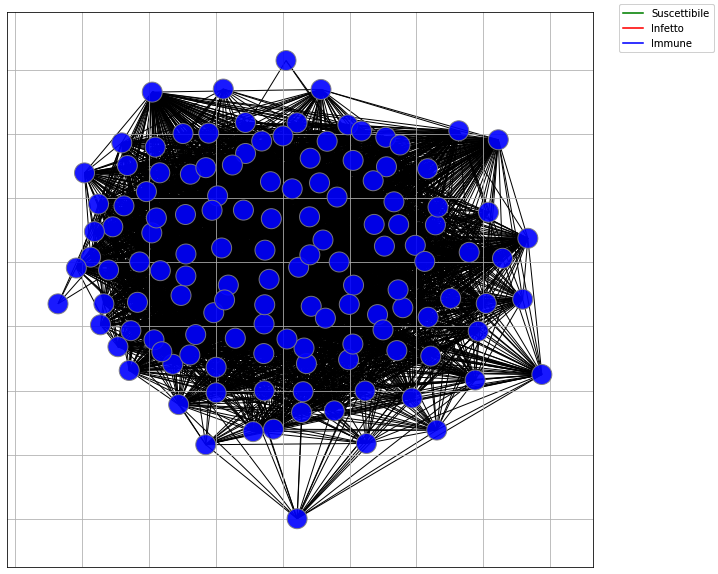

In [ ]:
sir_temporal_frames_directory = "./gif_temporal_data/gif_sir/" #modificare con gif_sirs ecc ecc
sirq_temporal_frames_directory = "./gif_temporal_data/gif_sirq/" #modificare con gif_sirs ecc ecc

temporal_network = Gs_cut
temporal_starting_infected_nodes = ['Ant298', 'Ant332', 'Ant564']
seed = RND_SEED

mia_prova = None
fig, ax = plt.subplots(1, figsize=(10,8))

result_temporal_sir = temporal_sir(temporal_network, temporal_starting_infected_nodes, seed, show_progress=True)
print()
print("Sir completato in", len(result_temporal_sir), "passaggi")
temporal_sir_frames = save_network_snapshots(fig, ax, result_temporal_sir, sir_temporal_frames_directory, frames_path, characteristic_name="epidemic_temporal_status")

result_temporal_sirq = temporal_sirq(temporal_network, temporal_starting_infected_nodes, seed, show_progress=True)
print()
print("Sirq completato in", len(result_temporal_sirq), "passaggi")
temporal_sirq_frames = save_network_snapshots(fig, ax, result_temporal_sirq, sirq_temporal_frames_directory, frames_path, characteristic_name="epidemic_temporal_status")

In [ ]:
# ESECUZIONE MODELLO DINAMICO
n_test = 5000 #Circa 25 secondi ogni 10 test -> 10k test circa 25000 secondi -> circa 417 minuti (7 ore)

temporal_sir_infects_distribution = []
temporal_sir_timing_distribution = []

temporal_sirq_infects_distribution = []
temporal_sirq_timing_distribution = []
seed = RND_SEED
show_progress = False
for cont in range (0, n_test):
    #if show_progress == True and cont % 100 == 0:
    #    drawProgressBar(cont / n_test)
    seed += 1
    # Faccio un modello con sir
    temporal_sir_result = temporal_sir(temporal_network, temporal_starting_infected_nodes, seed)
    temporal_sir_infects_distribution.insert(0, get_max_infection(temporal_sir_result))
    temporal_sir_timing_distribution.insert(0, len(temporal_sir_result))

    # Faccio un modello con sir_quarantine
    temporal_sirq_result = temporal_sirq(temporal_network, temporal_starting_infected_nodes, seed)
    temporal_sirq_infects_distribution.insert(0, get_max_infection(temporal_sirq_result))
    temporal_sirq_timing_distribution.insert(0, len(temporal_sirq_result))

# Salvo risultati su disco
save_temporal_data(temporal_sir_infects_distribution, temporal_sir_timing_distribution, temporal_sirq_infects_distribution, temporal_sirq_timing_distribution)

## Plot Results

### Generazione GIF di (SIR, SIS, SIRS) su rete aggregata

In [ ]:
# Metodo che salva una gif a partire da immagini
def create_temporal__gif(gif_path, frames_directory, frames_path, n_frames, frame_duration=1.5):
    with imageio.get_writer(gif_path, mode='I', duration=frame_duration) as writer: #duration = durata frames in secondi (?)
        for i in range(n_frames):
            writer.append_data(imageio.imread(frames_directory + frames_path.format(i=i)))

def create_gif(gif_path, frames_directory, frames_path, n_frames):
    # Creo la gif dalle immagini
    create_temporal__gif(gif_path, frames_directory, frames_path, n_frames)

In [ ]:
# Creo i vari paths per salvare le immagini
sir_gif_path = "./gif_data/agg_sir.gif" # anche qua modificare con sir.gif, sis.gif, sirs.

sis_gif_path = "./gif_data/agg_sis.gif" # anche qua modificare con sir.gif, sis.gif, sirs.

sirs_gif_path = "./gif_data/agg_sirs.gif" # anche qua modificare con sir.gif, sis.gif, sirs.

create_gif(sir_gif_path, sir_frames_directory, frames_path, dynamic_sir_frames)
create_gif(sis_gif_path, sis_frames_directory, frames_path, dynamic_sis_frames)
create_gif(sirs_gif_path, sirs_frames_directory, frames_path, dynamic_sirs_frames)

### Generazione GIF di (SIR, SIRQ) su rete temporale

In [ ]:
# Creo i vari paths per salvare le immagini
sir_temporal_gif_path = "./gif_temporal_data/temp_sir.gif"

sirq_temporal_gif_path = "./gif_temporal_data/temp_sirq.gif"

create_gif(sir_temporal_gif_path, sir_temporal_frames_directory, frames_path, temporal_sir_frames)
create_gif(sirq_temporal_gif_path, sirq_temporal_frames_directory, frames_path, temporal_sirq_frames)

### Plot Distribuzioni SIR vs SIRQ su rete aggregata

In [ ]:
# La gif rimane meglio senza sto tema (che sfoca molto anche i colori)
# imposto la roba mo che rende + belli i grafici
## dataviz setup
FONT_DIR = "./dataviz/fonts"
font_files = font_manager.findSystemFonts(fontpaths=FONT_DIR)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)


MATPLOTLIB_THEME_FILE = "./dataviz/mpl_theme.mplstyle"
plt.style.use(MATPLOTLIB_THEME_FILE)

theme = {"colors":{
            "avg_line": "blue",
            "avg_line_alpha": 0.5
         }, 
         "sizes": {
            "box_width": 0.3
         }}

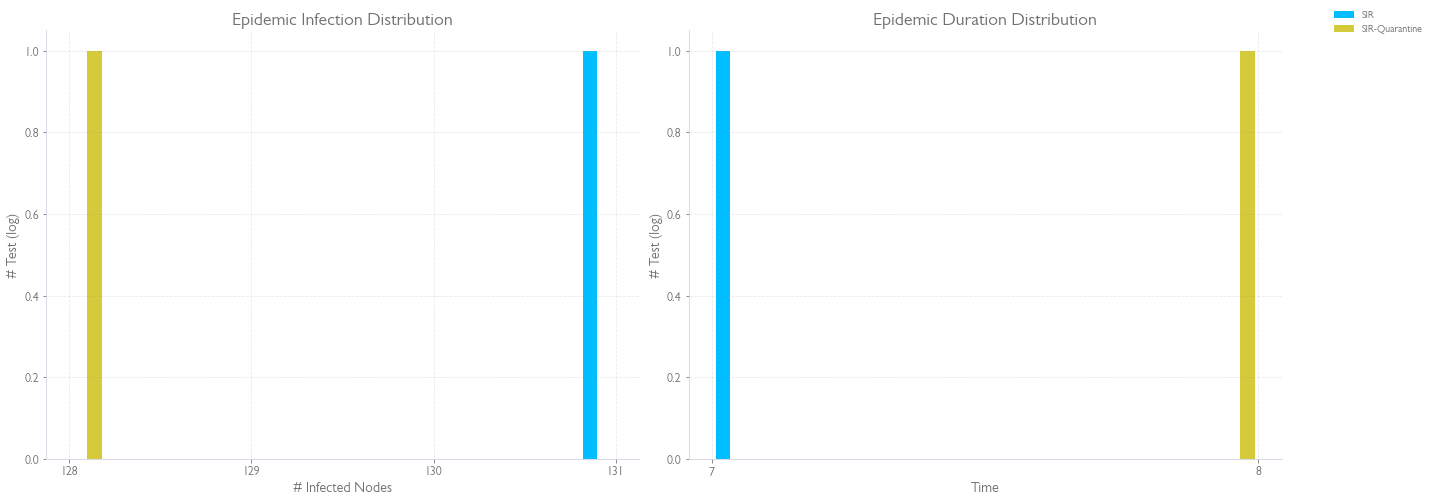

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18,7))
axes[0].hist([sir_infects_distribution, sirq_infects_distribution], bins=15, label=['SIR','SIR-Quarantine'])
axes[0].set(xlabel="# Infected Nodes", ylabel="# Test (log)", title="Epidemic Infection Distribution")
axes[0].xaxis.get_major_locator().set_params(integer=True)
#axes[0].set_yscale('log')

axes[1].hist([sir_timing_distribution, sirq_timing_distribution], bins=15, label=['SIR','SIR-Quarantine'])
axes[1].set(xlabel="Time", ylabel="# Test (log)", title="Epidemic Duration Distribution")
axes[1].xaxis.get_major_locator().set_params(integer=True)
#axes[1].set_yscale('log')

dviz.add_legend(fig, axes, on_fig=True)

figures['epidemic_aggregated_data_distribution'] = fig

### Plot Distribuzioni di SIR vs SIRQ su rete temporale

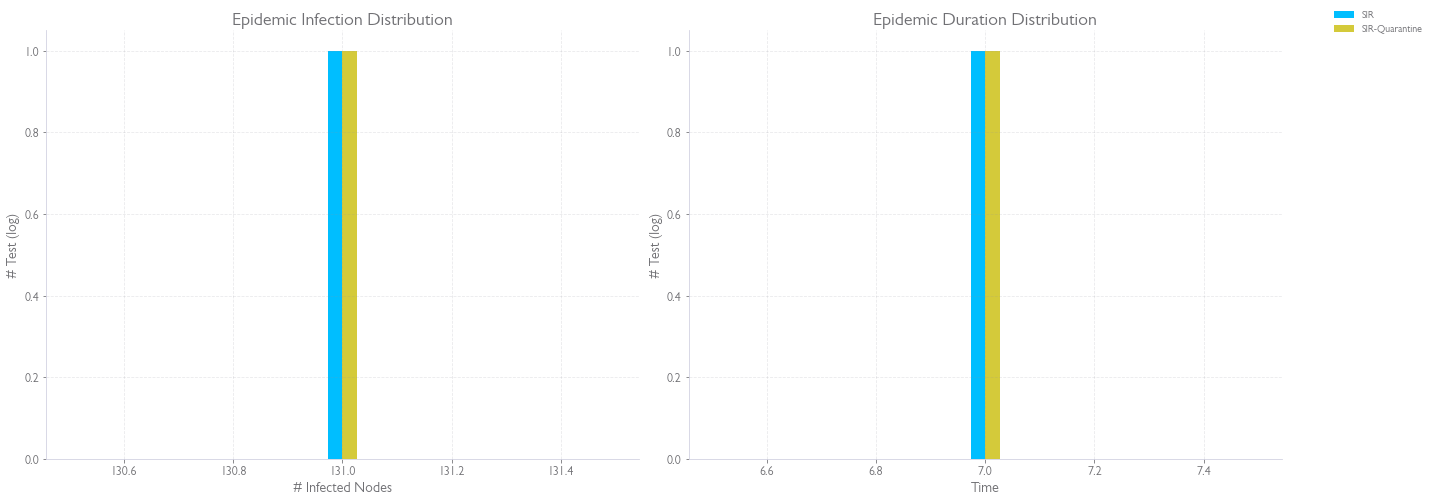

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18,7))
axes[0].hist([temporal_sir_infects_distribution, temporal_sirq_infects_distribution], bins=15, label=['SIR','SIR-Quarantine'])
axes[0].set(xlabel="# Infected Nodes", ylabel="# Test (log)", title="Epidemic Infection Distribution")
axes[0].xaxis.get_major_locator().set_params(integer=True)
#axes[0].set_yscale('log')

axes[1].hist([temporal_sir_timing_distribution, temporal_sirq_timing_distribution], bins=15, label=['SIR','SIR-Quarantine'])
axes[1].set(xlabel="Time", ylabel="# Test (log)", title="Epidemic Duration Distribution")
axes[1].xaxis.get_major_locator().set_params(integer=True)
#axes[1].set_yscale('log')

dviz.add_legend(fig, axes, on_fig=True)
fig.show()

figures['epidemic_temporal_data_distribution'] = fig

### Network Nodes Characteristics

In [ ]:
def plot_data_characteristic_distribution(G, queen, char, ax, title, bins=40, *mpl_args, **mpl_kwargs):
    char_bars = []
    for node_name in G.nodes:
        if node_name == queen:
            continue
        node = G.nodes[node_name]
        if node.get(char) == None:
            continue
        char_bars.insert(0, node[char])

    ax.hist(char_bars, bins=bins, alpha=0.8, **mpl_kwargs)
    ax.set(xlabel=char, ylabel="Frequency", title=title)
    ax.yaxis.get_major_locator().set_params(integer=True)

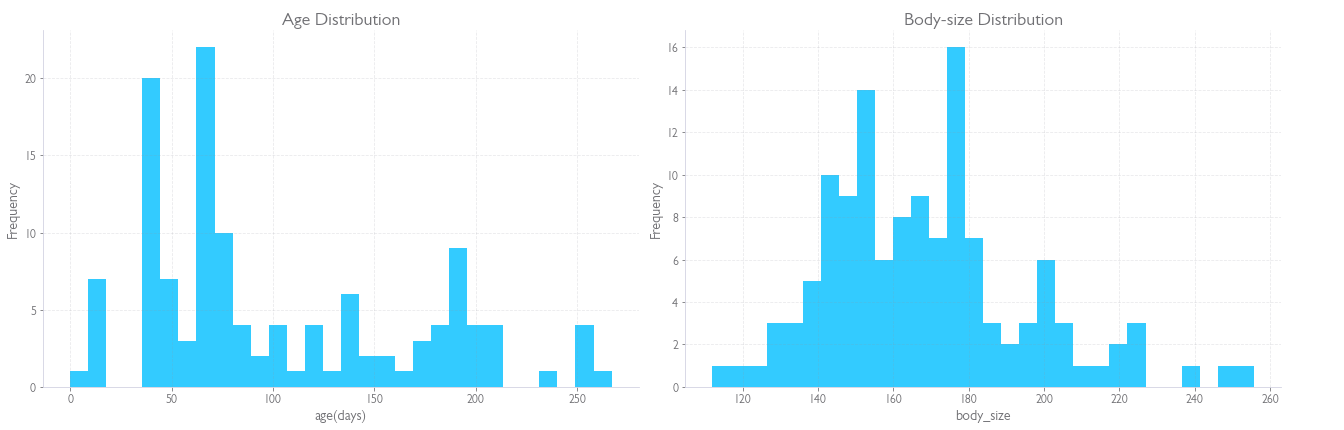

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18,6))

plot_data_characteristic_distribution(Gs_cut[0], temporal_data['queen'], "age(days)", axes[0], "Age Distribution", bins=30)
plot_data_characteristic_distribution(Gs_cut[0], temporal_data['queen'], "body_size", axes[1], "Body-size Distribution", bins=30)

dviz.add_legend(fig, axes, on_fig=True)
figures['network_characteristics_distribution'] = fig

## Export data

In [ ]:
from pathlib import Path
import string

def setup_figure_for_export(fig):
    # no title since we'll add a caption, but add a panel with letter 
    if len(fig.axes) > 1:
        for ax, panel_label in zip(fig.axes, string.ascii_uppercase):
            ax.set_title("")
            ax.text(0.97, 1., panel_label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
    else:
        fig.axes[0].set_title("")
    return fig

In [ ]:
EXPORT_DIR = Path("export")
formats  = ["pdf", "png"]

for name, fig in figures.items():
    for file_format in formats:
        file_path = EXPORT_DIR / f"{name}.{file_format}"
        print(f"saving {file_path}")
        fig = setup_figure_for_export(fig)
        fig.savefig(file_path)

saving export/epidemic_aggregated_data_distribution.pdf
saving export/epidemic_aggregated_data_distribution.png
saving export/epidemic_temporal_data_distribution.pdf
saving export/epidemic_temporal_data_distribution.png
saving export/network_characteristics_distribution.pdf
saving export/network_characteristics_distribution.png


## Test load data

In [ ]:
# Da eseguire solo se ci serve tirare fuori i dati
MY_TEST = True

if MY_TEST == True:
    # Sono una lista di 4 liste, in ordine:
    # 0 -sir_infects_distribution, 1 - sir_timing_distribution, 2 - sirq_infects_distribution, 3 - sirq_timing_distribution
    loaded_aggregated_data = load_aggregated_data()
    # In modo analogo ma per i dati temporali
    loaded_temporal_data = load_temporal_data()

## Questi due grafici dovrebbero essere uguali ai corrispettivi sopra delle Epidemic Infections ed Epidemic Duration

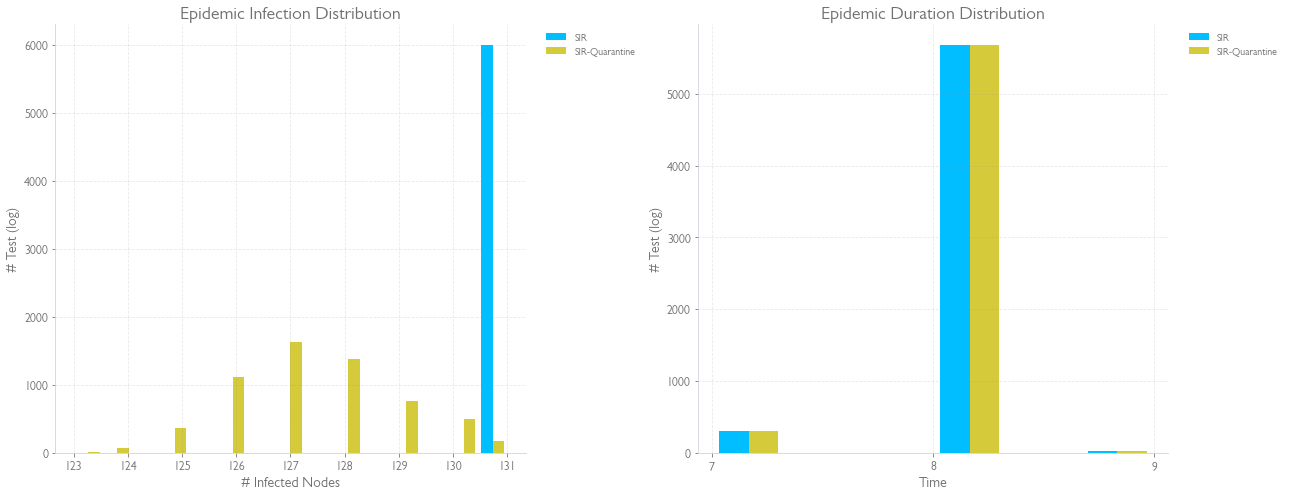

In [ ]:
if MY_TEST == True:
    fig, axes = plt.subplots(1,2, figsize=(18,7))
    axes[0].hist([loaded_aggregated_data[0], loaded_aggregated_data[2]], bins=15, label=['SIR','SIR-Quarantine'])
    axes[0].set(xlabel="# Infected Nodes", ylabel="# Test (log)", title="Epidemic Infection Distribution")
    axes[0].xaxis.get_major_locator().set_params(integer=True)
    #axes[0].set_yscale('log')

    axes[1].hist([loaded_aggregated_data[1], loaded_aggregated_data[3]], bins=6, label=['SIR','SIR-Quarantine'])
    axes[1].set(xlabel="Time", ylabel="# Test (log)", title="Epidemic Duration Distribution")
    axes[1].xaxis.get_major_locator().set_params(integer=True)
    #axes[1].set_yscale('log')
    dviz.add_legend(fig, axes)
    fig.show()

In [ ]:
if MY_TEST == True:
    fig, axes = plt.subplots(1,2, figsize=(18,7))
    axes[0].hist([loaded_temporal_data[0], loaded_temporal_data[2]], bins=15, label=['SIR','SIR-Quarantine'])
    axes[0].set(xlabel="# Infected Nodes", ylabel="# Test (log)", title="Epidemic Infection Distribution")
    axes[0].xaxis.get_major_locator().set_params(integer=True)
    #axes[0].set_yscale('log')

    axes[1].hist([loaded_temporal_data[1], loaded_temporal_data[3]], bins=15, label=['SIR','SIR-Quarantine'])
    axes[1].set(xlabel="Time", ylabel="# Test (log)", title="Epidemic Duration Distribution")
    axes[1].xaxis.get_major_locator().set_params(integer=True)
    #axes[1].set_yscale('log')

    fig.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cb57dfcf-e1ca-445d-8627-3e6f94f4b33f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>